## 🤖 Transformers 🤖

Dans ce notebook, on teste une version plus petite [CamemBERT-base](https://huggingface.co/almanach/camembert-base), appelée [DistilCamemBERT](https://huggingface.co/cmarkea/distilcamembert-base).

On teste l'extraction des plongements contextuels et leur utilisation avec des modèles d'apprentissage classiques ainsi qu'un apprentissage avec affinage.

In [2]:
! pip install datasets

In [3]:
! pip install transformers[torch]

In [4]:
! pip install evaluate

In [51]:
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt

# pour le découpage des données
import sklearn
from sklearn.model_selection import train_test_split

## 🗂️ Chargement et découpage des données

In [6]:
# Création du dossier data
!mkdir data
# Téléchargement des fichiers train et test dans le dossier data
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv

--2024-12-10 20:04:02--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289798 (283K) [text/plain]
Saving to: ‘data/test.csv’

test.csv            100%[===================>] 283.01K  --.-KB/s    in 0.01s   

2024-12-10 20:04:03 (20.9 MB/s) - ‘data/test.csv’ saved [289798/289798]

--2024-12-10 20:04:03--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

In [7]:
dtypes = dtype= {'label_fr': 'category',
                 'description': 'object',
                 'description_tokens': 'object',
                 'description_wosw': 'object',
                 'description_lemmas': 'object',
                 'simple': 'object',
                 'simple_tokens': 'object',
                 'simple_wosw': 'object',
                 'simple_lemmas': 'object',
                 'fautes': 'object',
                 'fautes_tokens': 'object',
                 'fautes_wosw': 'object',
                 'fautes_lemmas': 'object'}
train_df = pd.read_csv("data/train.csv", sep = ",", index_col=False, dtype=dtypes)

In [8]:
test_df = pd.read_csv("data/test.csv", sep = ",", index_col=False, dtype=dtypes)

In [9]:
# découpage des données d'entraînement en train and dev
train_df, dev_df = sklearn.model_selection.train_test_split(train_df, test_size=0.20, train_size=0.80, random_state=42, shuffle=True, stratify=None)

In [10]:
train_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   label_fr            486 non-null    category
 1   description         486 non-null    object  
 2   description_tokens  486 non-null    object  
 3   description_wosw    486 non-null    object  
 4   description_lemmas  486 non-null    object  
 5   simple              486 non-null    object  
 6   simple_tokens       486 non-null    object  
 7   simple_wosw         486 non-null    object  
 8   simple_lemmas       486 non-null    object  
 9   fautes              486 non-null    object  
 10  fautes_tokens       486 non-null    object  
 11  fautes_wosw         486 non-null    object  
 12  fautes_lemmas       486 non-null    object  
dtypes: category(1), object(12)
memory usage: 46.9+ KB


In [12]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   label_fr            122 non-null    category
 1   description         122 non-null    object  
 2   description_tokens  122 non-null    object  
 3   description_wosw    122 non-null    object  
 4   description_lemmas  122 non-null    object  
 5   simple              122 non-null    object  
 6   simple_tokens       122 non-null    object  
 7   simple_wosw         122 non-null    object  
 8   simple_lemmas       122 non-null    object  
 9   fautes              122 non-null    object  
 10  fautes_tokens       122 non-null    object  
 11  fautes_wosw         122 non-null    object  
 12  fautes_lemmas       122 non-null    object  
dtypes: category(1), object(12)
memory usage: 12.4+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   label_fr            152 non-null    category
 1   description         152 non-null    object  
 2   description_tokens  152 non-null    object  
 3   description_wosw    152 non-null    object  
 4   description_lemmas  152 non-null    object  
 5   simple              152 non-null    object  
 6   simple_tokens       152 non-null    object  
 7   simple_wosw         152 non-null    object  
 8   simple_lemmas       152 non-null    object  
 9   fautes              152 non-null    object  
 10  fautes_tokens       152 non-null    object  
 11  fautes_wosw         152 non-null    object  
 12  fautes_lemmas       152 non-null    object  
dtypes: category(1), object(12)
memory usage: 15.2+ KB


## Préparation des données

In [14]:
# Ajout d'un identifiant numérique à chaque classe
class_names = sorted(train_df.label_fr.unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}
print(label2id)
print(id2label)

{'acné': 0, 'allergie': 1, 'arthrite': 2, 'asthme bronchique': 3, 'dengue': 4, 'diabète': 5, 'hypertension': 6, 'impétigo': 7, 'infection fongique': 8, 'jaunisse': 9, 'migraine': 10, 'paludisme': 11, 'pneumonie': 12, 'psoriasis': 13, 'rhume': 14, 'réaction médicamenteuse': 15, 'spondylose cervicale': 16, 'typhoïde': 17, 'ulcère gastroduodénal': 18, 'varicelle': 19, 'varices': 20}
{0: 'acné', 1: 'allergie', 2: 'arthrite', 3: 'asthme bronchique', 4: 'dengue', 5: 'diabète', 6: 'hypertension', 7: 'impétigo', 8: 'infection fongique', 9: 'jaunisse', 10: 'migraine', 11: 'paludisme', 12: 'pneumonie', 13: 'psoriasis', 14: 'rhume', 15: 'réaction médicamenteuse', 16: 'spondylose cervicale', 17: 'typhoïde', 18: 'ulcère gastroduodénal', 19: 'varicelle', 20: 'varices'}


In [15]:
# Application de l'identifiant numérique sur les données de la rubrique label_fr
# Stockage dans une colonne "label"
train_df['label'] = train_df.label_fr.map(label2id)
train_df.head()

,label_fr,description,description_tokens,description_wosw,description_lemmas,simple,simple_tokens,simple_wosw,simple_lemmas,fautes,fautes_tokens,fautes_wosw,fautes_lemmas,label
0,jaunisse,"J'ai ressenti des démangeaisons intenses, des ...","J' ai ressenti des démangeaisons intenses , de...",ressenti démangeaisons intenses nausées épuise...,"je avoir ressentir un démangeaison intense , u...","J'ai eu beaucoup de démangeaisons, des nausées...","J' ai eu beaucoup de démangeaisons , des nausé...",beaucoup démangeaisons nausées fatigué forte f...,"je avoir avoir beaucoup de démangeaison , un n...","J'ai eu beaucoup de démangeaison, des nausée e...","J' ai eu beaucoup de démangeaison , des nausée...",beaucoup démangeaison nausée tré fatigué forte...,"je avoir avoir beaucoup de démangeaison , un n...",9
1,jaunisse,"Les démangeaisons, les nausées et la fatigue m...","Les démangeaisons , les nausées et la fatigue ...",démangeaisons nausées fatigue dérangé développ...,"le démangeaison , le nausée et le fatigue me a...","Je me gratte, j'ai envie de vomir et je suis t...","Je me gratte , j' ai envie de vomir et je suis...",gratte envie vomir fatigué fièvre perdu poids ...,"je me gratter , je avoir envier de vomir et je...","Je me gratte, j'ai envi de vomir et je suis tr...","Je me gratte , j' ai envi de vomir et je suis ...",gratte envi vomir tré fatigué fiévre perdu poi...,"je me gratter , je avoir envi de vomir et je ê...",9
2,asthme bronchique,"Récemment, je me sens très mal. Ma fièvre est ...","Récemment , je me sens très mal . Ma fièvre es...",Récemment sens mal fièvre élevée toux persista...,"récemment , je me sentir très mal . mon fièvre...","Je me sens très mal. J'ai beaucoup de fièvre, ...",Je me sens très mal . J' ai beaucoup de fièvre...,sens mal beaucoup fièvre toux part mal respire...,je me sentir très mal . je avoir beaucoup de f...,"Je me sens trè mal. J'ai beaucoup de fièvre, u...",Je me sens trè mal . J' ai beaucoup de fièvre ...,sens trè mal beaucoup fièvre toux mal respiré ...,je me sentir trè mal . je avoir beaucoup de fi...,3
3,varices,La peau de mes mollets est irritée et enflammé...,La peau de mes mollets est irritée et enflammé...,peau mollets irritée enflammée cause beaucoup ...,le peau de mon mollet être irriter et enflammé...,La peau de mes mollets me gratte et est enflée...,La peau de mes mollets me gratte et est enflée...,peau mollets gratte enflée mal empêche dormir ...,le peau de mon mollet me gratter et être enfle...,"La peau de mes mollet me gratte et est enflé, ...","La peau de mes mollet me gratte et est enflé ,...",peau mollet gratte enflé mal empêche dormir nu...,le peau de mon mollet me gratt et être enfler ...,20
4,spondylose cervicale,"J'ai eu des douleurs dans le dos, une toux sèc...","J' ai eu des douleurs dans le dos , une toux s...",douleurs dos toux sèche raideurs bras jambes p...,"je avoir avoir un douleur dans le dos , un tou...","J'ai mal au dos, je tousse sans arrêt et mes b...","J' ai mal au dos , je tousse sans arrêt et mes...",mal dos tousse arrêt bras jambes raides mal re...,"je avoir mal au dos , je tousser sans arrêt et...","J'ai mal au dos, je tousse sans arret et mes b...","J' ai mal au dos , je tousse sans arret et mes...",mal dos tousse arret bras jambe raide mal rest...,"je avoir mal au dos , je tousser sans arret et...",16


In [16]:
# pareil pour dev
dev_df['label'] = dev_df.label_fr.map(label2id)
dev_df.head()

,label_fr,description,description_tokens,description_wosw,description_lemmas,simple,simple_tokens,simple_wosw,simple_lemmas,fautes,fautes_tokens,fautes_wosw,fautes_lemmas,label
0,arthrite,"Récemment, j'ai ressenti une faiblesse muscula...","Récemment , j' ai ressenti une faiblesse muscu...",Récemment ressenti faiblesse musculaire cou ra...,"récemment , je avoir ressentir un faiblesse mu...","Récemment, j'ai eu des muscles faibles, un cou...","Récemment , j' ai eu des muscles faibles , un ...",Récemment muscles faibles cou raide articulati...,"récemment , je avoir avoir un muscle faible , ...","Récement, j'ai eu des muscl faible, un cou rai...","Récement , j' ai eu des muscl faible , un cou ...",Récement muscl faible cou raide articulation e...,"récement , je avoir avoir un muscl faible , un...",2
1,allergie,J'ai perdu l'appétit et j'ai du mal à avaler. ...,J' ai perdu l' appétit et j' ai du mal à avale...,perdu appétit mal avaler nez coule mal gorge,je avoir perdre le appétit et je avoir de mal ...,J'ai perdu l'appétit et j'ai du mal à avaler. ...,J' ai perdu l' appétit et j' ai du mal à avale...,perdu appétit mal avaler nez coule mal gorge,je avoir perdre le appétit et je avoir de mal ...,J'ai perdu l'apetit et j'ai du mal à avaler. M...,J' ai perdu l' apetit et j' ai du mal à avaler...,perdu apetit mal avaler néz coule mal gorge,je avoir perdre le apetit et je avoir de mal à...,1
2,rhume,"Je me sens très mal, avec beaucoup de congesti...","Je me sens très mal , avec beaucoup de congest...",sens mal beaucoup congestion nez coule beaucou...,"je me sentir très mal , avec beaucoup de conge...","Je me sens très mal, avec le nez bouché et qui...","Je me sens très mal , avec le nez bouché et qu...",sens mal nez bouché coule beaucoup toussé mal ...,"je me sentir très mal , avec le nez bouché et ...","Je me sen tré mal, avec le nez bouché et qui c...","Je me sen tré mal , avec le nez bouché et qui ...",sen tré mal nez bouché coule beaucou toussé ma...,"je me sen tré mal , avec le nez bouché et qui ...",14
3,migraine,En plus des maux de tête récurrents et de la v...,En plus des maux de tête récurrents et de la v...,maux tête récurrents vision floue souffre remo...,en plus un mal de tête récurrent et de le visi...,En plus d'avoir souvent mal à la tête et de vo...,En plus d' avoir souvent mal à la tête et de v...,mal tête voir flou remontées acides digère mal,en plus de avoir souvent mal à le tête et de v...,En plu d'avoir souvan mal a la tete et de voir...,En plu d' avoir souvan mal a la tete et de voi...,plu souvan mal tete voir flou remonte acide di...,en pleuvoir de avoir souvan mal avoir le tete ...,10
4,infection fongique,"Sur tout mon corps, j'ai tellement gratté que ...","Sur tout mon corps , j' ai tellement gratté qu...",corps gratté peau devenue rouge développé bout...,"sur tout mon corps , je avoir tellement gratte...","Sur tout mon corps, j'ai tellement gratté que ...","Sur tout mon corps , j' ai tellement gratté qu...",corps gratté peau devenue rouge boutons nodule...,"sur tout mon corps , je avoir tellement gratte...","Sur tout mon corps, j'ai tellement gratté que ...","Sur tout mon corps , j' ai tellement gratté qu...",corps gratté peau devenue rouge boutons nodule...,"sur tout mon corps , je avoir tellement gratte...",8


In [17]:
# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
target_columns = ["description_tokens", "label"]
train_ds = Dataset.from_pandas(train_df[target_columns], split="train")
dev_ds = Dataset.from_pandas(dev_df[target_columns], split="validation")
data = DatasetDict({"train": train_ds, "validation": dev_ds})

In [18]:
data['train'][0]

{'description_tokens': "J' ai ressenti des démangeaisons intenses , des nausées et de l' épuisement . J' ai aussi eu une forte fièvre et j' ai perdu du poids . Ma peau et mon urine sont devenues jaunes . De plus , j' ai mal à l' estomac .",
 'label': 9}

In [19]:
data['train'].features

{'description_tokens': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

## Tokénisation

In [20]:
#importation du modèle et du tokeniseur correspondant
model_ckpt = "cmarkea/distilcamembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

In [21]:
def preprocessing(dataset):
  return tokenizer(dataset['description_tokens'], padding=True, truncation = True)

In [22]:
tokenized_data = data.map(preprocessing, batched = True, batch_size = None)

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

In [23]:
# Taille du vocabulaire
tokenizer.vocab_size

32005

In [24]:
# Taille de contexte maximum
tokenizer.model_max_length

512

## Préparation de l'évaluation

In [25]:
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [26]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  acc = accuracy.compute(predictions=predictions, references=labels)
  f1 = f1_metric.compute(predictions=predictions, references=labels, average = "macro")
  return {"accuracy": acc["accuracy"], "f1-macro": f1["f1"]}

## Récuperation des plongements (sans affinage)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of CamembertModel were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Source : https://github.com/nlp-with-transformers/notebooks/blob/main/02_classification.ipynb
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = encoder_model(**inputs).last_hidden_state
    # Retourne le vecteur pour le token [CLS], qui est une représentation globale de la séquence
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [29]:
# Extraction des représentations vectorielles pour les données
tokenized_data.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# implementation de la fonction pour recupérer le hidden state
tokenized_data_hidden = tokenized_data.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

In [30]:
tokenized_data_hidden["train"].column_names

['description_tokens', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [31]:
# création des matrices des caractéristiques pour l'entraînement
# 768: taille des vecteurs
# 486: nb d'instances dans les données d'entraînement
# 122: nb d'instances dans les données dev
X_train = np.array(tokenized_data_hidden["train"]["hidden_state"])
X_valid = np.array(tokenized_data_hidden["validation"]["hidden_state"])
y_train = np.array(tokenized_data_hidden["train"]["label"])
y_valid = np.array(tokenized_data_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((486, 768), (122, 768))

## Entraînement d'un modèle d'apprentissage classique

Après avoir extrait les plongements contextuels, nous les testons avec les trois algorithmes qui se sont avérés les plus performants avec des plongements de type "sac de mots" lors de nos expériences avec les modèles d'apprentissage classiques (Linear SVC, Random Forest, Régression Logistique).


#### Linear SVC

In [40]:
from sklearn.svm import LinearSVC

SVC = LinearSVC(max_iter=300)
SVC.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=300)

In [41]:
print("Exactitude :", SVC.score(X_valid, y_valid))

Exactitude : 0.9016393442622951


#### Régression logistique

In [42]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [43]:
print("Exactitude :", lr_clf.score(X_valid, y_valid))

Exactitude : 0.8770491803278688


#### Random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
print("Exactitude :", rf.score(X_valid, y_valid))

Exactitude : 0.8360655737704918


In [59]:
results_trans_woft_df = pd.DataFrame(
    [
        ["Random Forest", rf.score(X_valid, y_valid)],
        ["Logistic Regression", lr_clf.score(X_valid, y_valid)],
        ["SVC", SVC.score(X_valid, y_valid)]
    ],
    columns=["Modèle", "Exactitude"]
)
results_trans_woft_df

,Modèle,Exactitude
0,Random Forest,0.836066
1,Logistic Regression,0.877049
2,SVC,0.901639


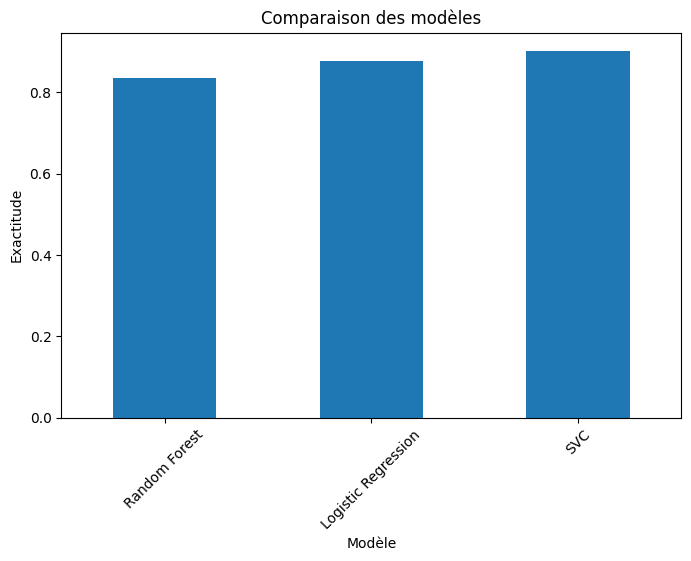

In [60]:
results_trans_woft_df.set_index("Modèle", inplace=True)

results_trans_woft_df.plot(kind="bar", figsize=(8, 5), legend=False)

plt.title("Comparaison des modèles")
plt.ylabel("Exactitude")
plt.xticks(rotation=45)

plt.show()

On voit que le modèle qui a les meilleures performances est Linear SVC comme c'était le cas aussi avec les plongements créés avec l'approche de sac des mots. Il est toutefois à noter que les perfomances ne sont pas meilleurs que celles obtenues sans plongements contextuels.

## Entraînement par affinage

In [32]:
batch_size = 32
training_args = TrainingArguments(
    # dossier pour le sauvegarde du modèle. On peut récupérer le modèle affiné
    output_dir=f"{model_ckpt}-finetuned-med",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # nb total d'époques
    num_train_epochs=10,
    weight_decay=0.01,
    # évaluer à chaque époque
    evaluation_strategy="epoch",
    # sauvegarder le modèle, à la fin de chaque époque.
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def init_trainer():
  model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(class_names), id2label=id2label, label2id=label2id
    ).to(device)
  return Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_data["train"],
      eval_dataset=tokenized_data["validation"],
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  ), model

In [ ]:
trainer, model = init_trainer()

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-66-26289ba17cd6>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,No log,2.960233,0.081967,0.027116
2,No log,2.836625,0.213115,0.120568
3,No log,2.687875,0.418033,0.325810
4,No log,2.496894,0.500000,0.347327
5,No log,2.304497,0.516393,0.360014
6,No log,2.152114,0.549180,0.396687
7,No log,2.042216,0.557377,0.405197
8,No log,1.967619,0.565574,0.415647
9,No log,1.922373,0.598361,0.452047
10,No log,1.908844,0.598361,0.452047


TrainOutput(global_step=160, training_loss=2.3228919982910154, metrics={'train_runtime': 2808.5479, 'train_samples_per_second': 1.73, 'train_steps_per_second': 0.057, 'total_flos': 134587964341080.0, 'train_loss': 2.3228919982910154, 'epoch': 10.0})

Les résultats de l'entraînement par affinage sont mauvais, même après 10 époques. Cela nous montre que peut-être le modèle est trop compliqué par rapport à la tâche ou que les données ne sont pas suffisantes pour l'affinage. Étant donné la petite taille de notre corpus, les autres méthodes ont été beaucoup plus performantes.

In [61]:
results_trans_ft_df = pd.DataFrame({
    "DistilBERT affiné": [0.598361]
})

results_trans_ft_df

,DistilBERT affiné
0,0.598361


In [62]:
! mkdir results
results_trans_ft_df.to_csv("results/results_transformers_ft.csv", index=False)
results_trans_woft_df.to_csv("results/results_transformers_noft.csv", index=False)